In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [2]:
pd.options.display.float_format= '{:.2f}'.format

# Загрузка и анализ датасета

In [3]:
data_full = pd.read_csv('train.csv')
data_full.head()

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot o...,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry


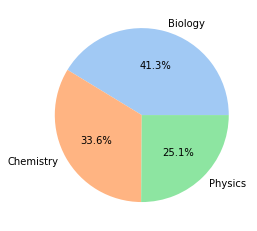

In [4]:
v, c = np.unique(data_full['Topic'], return_counts=True)
plt.pie(c, labels=v,
        colors=sns.color_palette('pastel'),
        autopct='%.1f%%');

In [5]:
print(f'Количество строк: {data_full.shape[0]}\nКоличество столбцов: {data_full.shape[1]}')
data_dict = {'Тип':data_full.dtypes,
             'Количество Nan':data_full.isnull().sum(),
             'Количество уникальных':[data_full[i].unique().shape[0] for i in data_full.columns],
             'Уникальные значения':[data_full[i].unique() for i in data_full.columns]}
df_descriptive_statistics = pd.DataFrame.from_dict(data_dict,
                                                   orient='columns')
df_descriptive_statistics

Количество строк: 8695
Количество столбцов: 3


,Тип,Количество Nan,Количество уникальных,Уникальные значения
Id,object,0,8695,"[0x840, 0xbf0, 0x1dfc, 0xc7e, 0xbba, 0xb39, 0x..."
Comment,object,0,7950,[A few things. You might have negative- freque...
Topic,object,0,3,"[Biology, Physics, Chemistry]"


In [6]:
data_full = data_full.drop('Id', axis=1)

In [7]:
X_dirty = data_full['Comment']
y_dirty = data_full['Topic']

In [8]:
X_dirty.shape, y_dirty.shape

((8695,), (8695,))

In [9]:
data_full[data_full.duplicated()]

,Comment,Topic
84,[removed],Physics
86,[removed],Physics
108,[removed],Physics
115,[removed],Physics
176,[removed],Physics
...,...,...
8669,Thank you!,Chemistry
8681,Nice,Chemistry
8685,Thank you for your kindness <3 Found this [inj...,Biology
8690,I make similar observations over the last week...,Biology


In [10]:
data_full[data_full['Comment']=='What about the ethical delimmas,  groundbreaking technology, and future research in the field of genetic engineering. Is it safe? What are the strengths?. What are the benefits and whereare we headed? Amongst different cultural and spiritual dynamics, where do we draw the line when it comes to a want and a need? What risks are present and possible for the future of the field?']

,Comment,Topic
7305,"What about the ethical delimmas, groundbreaki...",Biology
8693,"What about the ethical delimmas, groundbreaki...",Biology


In [11]:
index_list = data_full[data_full['Comment']=='[removed]'].index
data_full = data_full.drop(index_list, axis=0).reset_index(drop=True)

In [12]:
data_full = data_full.drop_duplicates()
data_full = data_full.reset_index(drop=True)
data_full.shape

(7970, 2)

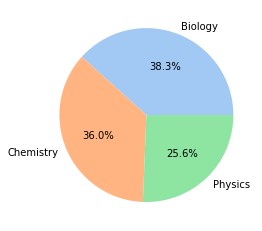

In [13]:
v, c = np.unique(data_full['Topic'], return_counts=True)
plt.pie(c, labels=v,
        colors=sns.color_palette('pastel'),
        autopct='%.1f%%');

In [14]:
from wordcloud import WordCloud

In [15]:
all_comments_ = [row.Comment for index, row in data_full.iterrows()]
all_comments = ''
for s in all_comments_:
    all_comments += s

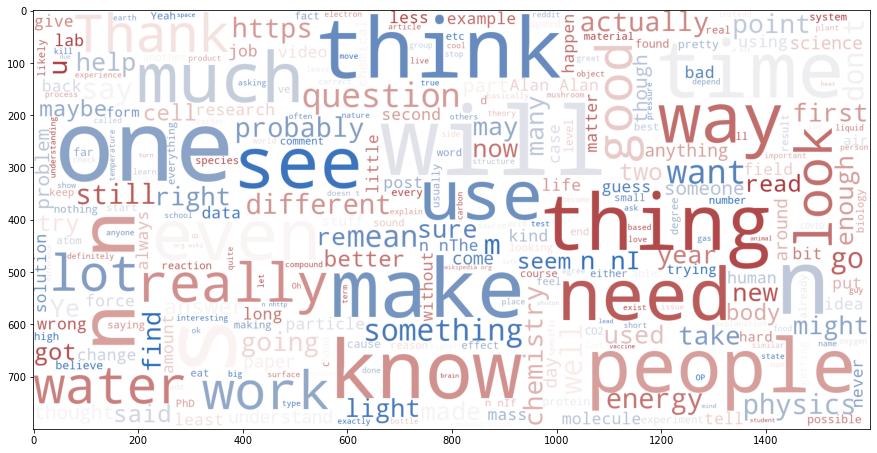

In [16]:
cloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=300, colormap='vlag',background_color="white", collocations=True).generate(all_comments)
plt.figure(figsize=(15,10))
plt.imshow(cloud);

In [17]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\xeniy\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [18]:
data = data_full[['Topic', 'Comment']]
data['words'] = [nltk.word_tokenize(row.Comment) for index, row in data.iterrows()] # dirty version

<ipython-input-18-da4ba74da694>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['words'] = [nltk.word_tokenize(row.Comment) for index, row in data.iterrows()] # dirty version


In [19]:
def comments_statistics(col):
    df = pd.DataFrame(None)
    comments_length = []
    short_comments = []
    for index, row in data.iterrows():
        words = word_tokenize(row[col])
        if len(words) < 1:
            short_comments.append(index)
        comments_length.append(len(words))
    df['Средняя длина комментария'] = [round(np.mean(comments_length), 2)]
    df['Длина самого короткого комментария'] = [min(comments_length)]
    df['Длина самого длинного комментария'] = [max(comments_length)]
    return (df.T, short_comments)

In [20]:
df, ind = comments_statistics('Comment')
df

,0
Средняя длина комментария,35.10
Длина самого короткого комментария,1.00
Длина самого длинного комментария,1481.00


In [21]:
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^\w\d+\s,.?!]', '', text) # есть смайлики
    text = re.sub(r'[!?.#$%&()*+,-/:;<=>@^_`{}~\'\"—-’\[\]–ー]', ' ', text)
    symbls  = ['\\n', '\xa0', '\u2005', '\t', '\r'] 
    for s in symbls:
        text = text.replace(s, ' ')

    return text

In [22]:
# частичная очистка от ненужных символов
data['text_wo_punkt'] = [preprocessing(row.Comment) for index, row in data.iterrows()]

<ipython-input-22-635eb268a017>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_wo_punkt'] = [preprocessing(row.Comment) for index, row in data.iterrows()]


In [23]:
data.head()

,Topic,Comment,words,text_wo_punkt
0,Biology,A few things. You might have negative- frequen...,"[A, few, things, ., You, might, have, negative...",a few things you might have negative frequenc...
1,Physics,Is it so hard to believe that there exist part...,"[Is, it, so, hard, to, believe, that, there, e...",is it so hard to believe that there exist part...
2,Biology,There are bees,"[There, are, bees]",there are bees
3,Biology,I'm a medication technician. And that's alot o...,"[I, 'm, a, medication, technician, ., And, tha...",im a medication technician and thats alot of ...
4,Chemistry,Cesium is such a pretty metal.,"[Cesium, is, such, a, pretty, metal, .]",cesium is such a pretty metal


In [24]:
for index, row in data.iterrows():
    print('Исходный текст:', '\n')
    print(row.Comment, '\n\n\n')
    print('Очищенный текст:', '\n')
    print(row.text_wo_punkt)
    break

Исходный текст: 

A few things. You might have negative- frequency dependent selection going on where the least common phenotype, reflected by genotype, is going to have an advantage in the environment. For instance, if a prey animal such as a vole were to have a light and a dark phenotype, a predator might recognize the more common phenotype as food.  So if the light voles are more common, foxes may be keeping a closer eye out for light phenotypic voles, recognising them as good prey. This would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed. This cycle continues perpetually. \n\nHowever, this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness. \n\nMore likely on a *year to year* basis, the population is experiencing fluctuating sele

In [25]:
data.isnull().sum()

Topic            0
Comment          0
words            0
text_wo_punkt    0
dtype: int64

In [26]:
all_symbols = []
for index, row in data.iterrows():
    for symb in list(row.text_wo_punkt):
        if symb not in all_symbols:
            all_symbols.append(symb)
print(all_symbols)

['a', ' ', 'f', 'e', 'w', 't', 'h', 'i', 'n', 'g', 's', 'y', 'o', 'u', 'm', 'v', 'r', 'q', 'c', 'd', 'p', 'l', 'b', 'k', 'z', 'x', 'j', '3', '0', '2', '4', '8', '1', '5', '7', '6', '9', 'ø', 'μ', 'µ', 'ñ', 'é', 'ç', 'ä', 'õ', 'ö', 'ó', 'á', '₂', '₃', 'å', 'ν', 'ã', 'í', '²', 'ê', 'ψ', 'ч', 'е', 'р', 'н', 'о', 'б', 'ы', 'л', 'ь', '³', 'ú', '⁷', 'ℝ', '¾', 'γ', 'φ', 'ϕ', 'è', 'ü', 'æ', 'ا', 'ل', 'ه', 'ک', 'ب', 'ر']


In [27]:
set(stopwords.words('english')), len(set(stopwords.words('english')))

({'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',
  'myself',
  'needn',
  "needn't",
  'no',
  'nor',
  'not',
  'now',
  'o',
  'of',
  'off',
 

In [28]:
stops_ = set(stopwords.words('english'))
stops = []
for word in stops_:
    if word.find("'") != -1:
        w = word
        stops.append(w.replace("'", ' '))
        stops.append(w.replace("'", ''))
    else:
        stops.append(word)
stops.append('im')
stops.append('cant')
stops

['ourselves',
 'hers',
 'can',
 'shan',
 'our',
 'against',
 'each',
 'aren t',
 'arent',
 'if',
 'while',
 'between',
 'won',
 'your',
 'needn t',
 'neednt',
 'its',
 'until',
 'wouldn t',
 'wouldnt',
 'more',
 'you ll',
 'youll',
 'he',
 'why',
 'shan t',
 'shant',
 'she',
 'have',
 'below',
 'i',
 'the',
 'again',
 'only',
 'before',
 'will',
 'we',
 'that ll',
 'thatll',
 'other',
 'for',
 'an',
 'some',
 'was',
 'doing',
 'with',
 'weren t',
 'werent',
 'about',
 'am',
 'm',
 'me',
 'yourself',
 'shouldn t',
 'shouldnt',
 'there',
 'didn t',
 'didnt',
 'does',
 'same',
 'so',
 'and',
 'on',
 'ours',
 'above',
 'themselves',
 'you d',
 'youd',
 'don',
 'be',
 'won t',
 'wont',
 'she s',
 'shes',
 'ma',
 'hasn t',
 'hasnt',
 'it',
 'hasn',
 'yours',
 'doesn',
 'y',
 't',
 'hadn',
 'but',
 'just',
 'should ve',
 'shouldve',
 'myself',
 'by',
 'who',
 'what',
 'couldn t',
 'couldnt',
 'down',
 'once',
 's',
 'haven t',
 'havent',
 'these',
 'mustn',
 'here',
 'isn t',
 'isnt',
 'few',

In [29]:
data['words_wo_punkt_wo_stopwords'] = [[word for word in word_tokenize(row.text_wo_punkt) if word not in stops] for index, row in data.iterrows()]
data['text_wo_punkt_wo_stopwords'] =  [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows()]

<ipython-input-29-0e166dc31e7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['words_wo_punkt_wo_stopwords'] = [[word for word in word_tokenize(row.text_wo_punkt) if word not in stops] for index, row in data.iterrows()]
<ipython-input-29-0e166dc31e7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_wo_punkt_wo_stopwords'] =  [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows()]


In [30]:
for index, row in data.iterrows():
    print('Исходный текст:', '\n')
    print(row.Comment, '\n\n\n')
    print('Очищенный текст:', '\n')
    print(row.text_wo_punkt_wo_stopwords)
    break

Исходный текст: 

A few things. You might have negative- frequency dependent selection going on where the least common phenotype, reflected by genotype, is going to have an advantage in the environment. For instance, if a prey animal such as a vole were to have a light and a dark phenotype, a predator might recognize the more common phenotype as food.  So if the light voles are more common, foxes may be keeping a closer eye out for light phenotypic voles, recognising them as good prey. This would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed. This cycle continues perpetually. \n\nHowever, this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness. \n\nMore likely on a *year to year* basis, the population is experiencing fluctuating sele

In [31]:
df, ind = comments_statistics('text_wo_punkt_wo_stopwords')
df

,0
Средняя длина комментария,15.95
Длина самого короткого комментария,0.00
Длина самого длинного комментария,572.00


In [32]:
data.iloc[ind[0]]

Topic                             Biology
Comment                           Then no
words                          [Then, no]
text_wo_punkt                     then no
words_wo_punkt_wo_stopwords            []
text_wo_punkt_wo_stopwords               
Name: 123, dtype: object

In [33]:
data = data.drop(ind, axis=0).reset_index(drop=True)

In [34]:
all_comments_ = [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows()]
all_comments = ''
for s in all_comments_:
    all_comments += s

<Figure size 1440x720 with 0 Axes>

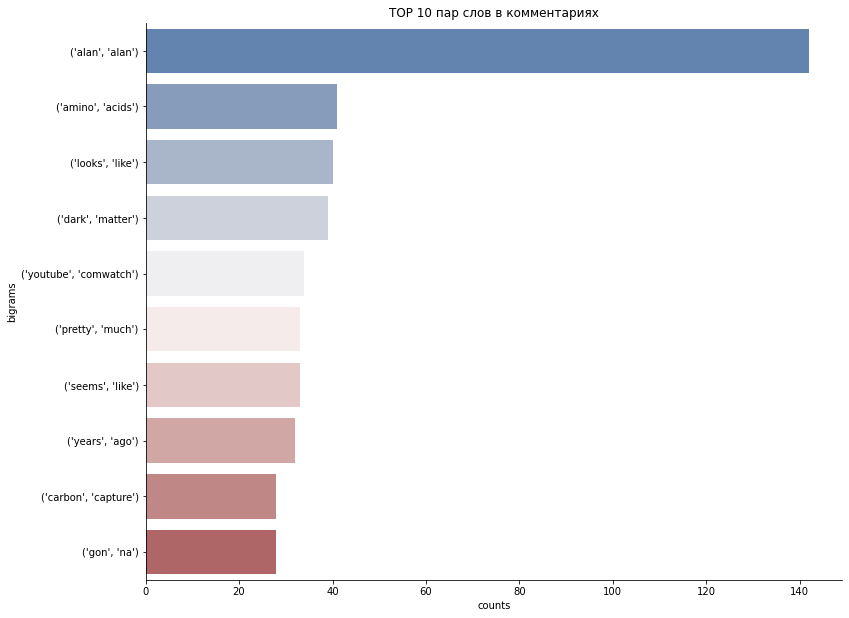

In [35]:
# Создаем датасет самых частотных биграммов

bigrams_series = (pd.Series(nltk.ngrams(word_tokenize(all_comments), 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграммов
plt.figure(figsize=(20,10))
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="vlag", data=bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title('TOP 10 пар слов в комментариях');

In [36]:
data = data.reset_index(drop=True)
for index, row in data.iterrows():
    if 'alan alan' in row.text_wo_punkt_wo_stopwords:
        print('Индекс комментария:', index)
        print(row.Comment, '\n')

Индекс комментария: 4170
Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! Alan! \n\nEtc 



In [37]:
data = data.drop(4170, axis=0).reset_index(drop=True)

In [38]:
ps = PorterStemmer()
data['words_clean'] = [[ps.stem(word) for word in word_tokenize(row.text_wo_punkt_wo_stopwords)] for index, row in data.iterrows()]
data['text_clean'] = [' '.join(row.words_clean) for index, row in data.iterrows()]

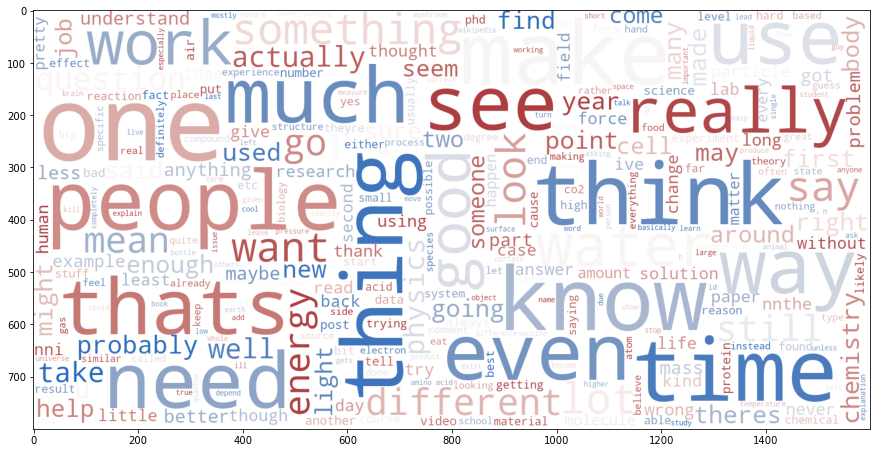

In [39]:
all_comments_ = [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows()]
all_comments = ''
for s in all_comments_:
    all_comments += s
cloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=300, colormap='vlag',background_color="white", collocations=True).generate(all_comments)
plt.figure(figsize=(15,10))
plt.imshow(cloud);

In [40]:
biology_comments_ = [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows() if row.Topic=='Biology']
biology_comments = ''
for s in biology_comments_:
    biology_comments += s
    
    
physics_comments_ = [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows() if row.Topic=='Physics']
physics_comments = ''
for s in physics_comments_:
    physics_comments += s
    
chemistry_comments_ = [' '.join(row.words_wo_punkt_wo_stopwords) for index, row in data.iterrows() if row.Topic=='Chemistry']
chemistry_comments = ''
for s in chemistry_comments_:
    chemistry_comments += s

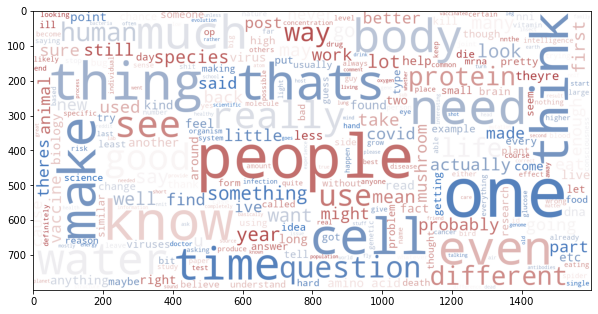

In [41]:
cloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=300, colormap='vlag',background_color="white", collocations=True).generate(biology_comments)
plt.figure(figsize=(10,10))
plt.imshow(cloud);

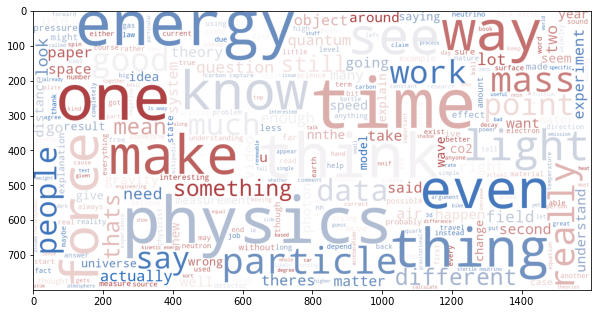

In [42]:
cloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=300, colormap='vlag',background_color="white", collocations=True).generate(physics_comments)
plt.figure(figsize=(10,10))
plt.imshow(cloud);

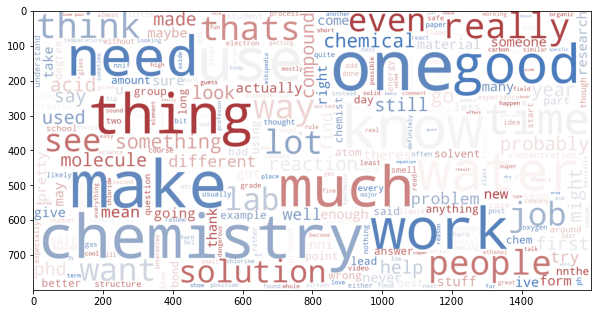

In [43]:
cloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=300, colormap='vlag',background_color="white", collocations=True).generate(chemistry_comments)
plt.figure(figsize=(10,10))
plt.imshow(cloud);

# Подготовка данных, модели и метрик

In [44]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import time

In [45]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(data['Topic'])
le = preprocessing.LabelEncoder()
y_dirty = le.fit_transform(y_dirty)

In [46]:
le.classes_

array(['Biology', 'Chemistry', 'Physics'], dtype=object)

# Извлечение признаков

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
import time

In [48]:
data.head()

,Topic,Comment,words,text_wo_punkt,words_wo_punkt_wo_stopwords,text_wo_punkt_wo_stopwords,words_clean,text_clean
0,Biology,A few things. You might have negative- frequen...,"[A, few, things, ., You, might, have, negative...",a few things you might have negative frequenc...,"[things, might, negative, frequency, dependent...",things might negative frequency dependent sele...,"[thing, might, neg, frequenc, depend, select, ...",thing might neg frequenc depend select go leas...
1,Physics,Is it so hard to believe that there exist part...,"[Is, it, so, hard, to, believe, that, there, e...",is it so hard to believe that there exist part...,"[hard, believe, exist, particulars, detect, an...",hard believe exist particulars detect anything...,"[hard, believ, exist, particular, detect, anyt...",hard believ exist particular detect anyth weve...
2,Biology,There are bees,"[There, are, bees]",there are bees,[bees],bees,[bee],bee
3,Biology,I'm a medication technician. And that's alot o...,"[I, 'm, a, medication, technician, ., And, tha...",im a medication technician and thats alot of ...,"[medication, technician, thats, alot, drugs, l...",medication technician thats alot drugs liver p...,"[medic, technician, that, alot, drug, liver, p...",medic technician that alot drug liver probabl ...
4,Chemistry,Cesium is such a pretty metal.,"[Cesium, is, such, a, pretty, metal, .]",cesium is such a pretty metal,"[cesium, pretty, metal]",cesium pretty metal,"[cesium, pretti, metal]",cesium pretti metal


In [49]:
df = pd.DataFrame(None, columns=['Описание', 'Train_accuracy', 'Test_accuracy', 
                                'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
                                'Train_f1', 'Test_f1', 'Time'])

In [50]:
batch_size=32

# CountVectorizer

In [51]:
# неочищенный
description = 'Исходный, CountVectorizer(min_df=0)'
vect = CountVectorizer(min_df=0)
X = vect.fit_transform(X_dirty).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y_dirty,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y_dirty)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
218/218 [==============================] - 3s 8ms/step - loss: 2.1588 - accuracy: 0.4235 - val_loss: 1.4247 - val_accuracy: 0.4267
Epoch 2/10
218/218 [==============================] - 1s 6ms/step - loss: 1.1166 - accuracy: 0.4757 - val_loss: 1.3180 - val_accuracy: 0.4445
Epoch 3/10
218/218 [==============================] - 1s 6ms/step - loss: 1.0621 - accuracy: 0.4797 - val_loss: 1.2936 - val_accuracy: 0.4428
Epoch 4/10
218/218 [==============================] - 1s 6ms/step - loss: 1.0498 - accuracy: 0.4815 - val_loss: 1.2113 - val_accuracy: 0.4376
Epoch 5/10
218/218 [==============================] - 1s 7ms/step - loss: 1.0392 - accuracy: 0.4881 - val_loss: 1.2096 - val_accuracy: 0.4370
Epoch 6/10
218/218 [==============================] - 2s 7ms/step - loss: 1.0374 - accuracy: 0.4899 - val_loss: 1.1810 - val_accuracy: 0.4393
Epoch 7/10
218/218 [==============================] - 1s 7ms/step - loss: 1.0379 - accuracy: 0.4839 - val_loss: 1.1805 - val_accuracy: 0.4422
Epoch 

In [52]:
# неочищенный
description = 'Исходный, CountVectorizer(min_df=2)'
vect = CountVectorizer(min_df=2)
X = vect.fit_transform(X_dirty).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y_dirty,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y_dirty)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
218/218 [==============================] - 4s 7ms/step - loss: 1.8609 - accuracy: 0.4045 - val_loss: 1.2295 - val_accuracy: 0.4129
Epoch 2/10
218/218 [==============================] - 2s 7ms/step - loss: 1.1132 - accuracy: 0.4303 - val_loss: 1.2482 - val_accuracy: 0.4342
Epoch 3/10
218/218 [==============================] - 2s 7ms/step - loss: 1.0764 - accuracy: 0.4370 - val_loss: 1.2229 - val_accuracy: 0.4255
Epoch 4/10
218/218 [==============================] - 2s 8ms/step - loss: 1.0666 - accuracy: 0.4383 - val_loss: 1.2183 - val_accuracy: 0.4227
Epoch 5/10
218/218 [==============================] - 1s 6ms/step - loss: 1.0667 - accuracy: 0.4383 - val_loss: 1.2190 - val_accuracy: 0.4227
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 1.0633 - accuracy: 0.4405 - val_loss: 1.2213 - val_accuracy: 0.4238
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 1.0639 - accuracy: 0.4432 - val_loss: 1.2172 - val_accuracy: 0.4181
Epoch 

In [53]:
# очищенный
description = 'Очищенный, CountVectorizer(min_df=0)'
vect = CountVectorizer(min_df=0)
X = vect.fit_transform(data.text_wo_punkt_wo_stopwords).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 3s 10ms/step - loss: 2.0958 - accuracy: 0.4036 - val_loss: 1.2190 - val_accuracy: 0.4306
Epoch 2/10
198/198 [==============================] - 2s 11ms/step - loss: 1.0466 - accuracy: 0.4776 - val_loss: 1.2318 - val_accuracy: 0.4451
Epoch 3/10
198/198 [==============================] - 2s 9ms/step - loss: 1.0363 - accuracy: 0.4809 - val_loss: 1.1771 - val_accuracy: 0.4318
Epoch 4/10
198/198 [==============================] - 2s 9ms/step - loss: 1.0309 - accuracy: 0.4923 - val_loss: 1.1460 - val_accuracy: 0.4489
Epoch 5/10
198/198 [==============================] - 1s 7ms/step - loss: 1.0270 - accuracy: 0.4965 - val_loss: 1.1592 - val_accuracy: 0.4558
Epoch 6/10
198/198 [==============================] - 1s 7ms/step - loss: 1.0191 - accuracy: 0.5118 - val_loss: 1.1774 - val_accuracy: 0.4634
Epoch 7/10
198/198 [==============================] - 1s 7ms/step - loss: 1.0137 - accuracy: 0.5122 - val_loss: 1.1879 - val_accuracy: 0.4665
Epoc

In [54]:
# очищенный
description = 'Очищенный, CountVectorizer(min_df=2)'
vect = CountVectorizer(min_df=2)
X = vect.fit_transform(data.text_wo_punkt_wo_stopwords).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 1s 5ms/step - loss: 2.2756 - accuracy: 0.4373 - val_loss: 1.3861 - val_accuracy: 0.4640
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0455 - accuracy: 0.5021 - val_loss: 1.3575 - val_accuracy: 0.4678
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0324 - accuracy: 0.5126 - val_loss: 1.3096 - val_accuracy: 0.4640
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0109 - accuracy: 0.5205 - val_loss: 1.3064 - val_accuracy: 0.4773
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0077 - accuracy: 0.5219 - val_loss: 1.2392 - val_accuracy: 0.4823
Epoch 6/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0055 - accuracy: 0.5333 - val_loss: 1.2148 - val_accuracy: 0.4722
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0102 - accuracy: 0.5361 - val_loss: 1.2313 - val_accuracy: 0.4924
Epoch 

In [55]:
# очищенный
description = 'Очищенный (stemming), CountVectorizer(min_df=0)'
vect = CountVectorizer(min_df=0)
X = vect.fit_transform(data.text_clean).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 3s 9ms/step - loss: 2.0913 - accuracy: 0.4249 - val_loss: 1.1607 - val_accuracy: 0.4369
Epoch 2/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0488 - accuracy: 0.4815 - val_loss: 1.1800 - val_accuracy: 0.4596
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0483 - accuracy: 0.4924 - val_loss: 1.1944 - val_accuracy: 0.4729
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 1.0371 - accuracy: 0.5013 - val_loss: 1.1818 - val_accuracy: 0.4779
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0315 - accuracy: 0.5022 - val_loss: 1.1771 - val_accuracy: 0.4842
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0222 - accuracy: 0.5110 - val_loss: 1.1750 - val_accuracy: 0.4836
Epoch 7/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0163 - accuracy: 0.5170 - val_loss: 1.1815 - val_accuracy: 0.4855
Epoch 

In [56]:
# очищенный
description = 'Очищенный (stemming), CountVectorizer(min_df=2)'
vect = CountVectorizer(min_df=2)
X = vect.fit_transform(data.text_clean).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 1s 4ms/step - loss: 2.6002 - accuracy: 0.4410 - val_loss: 1.5294 - val_accuracy: 0.4729
Epoch 2/10
198/198 [==============================] - 1s 3ms/step - loss: 1.0662 - accuracy: 0.5227 - val_loss: 1.4541 - val_accuracy: 0.4836
Epoch 3/10
198/198 [==============================] - 1s 3ms/step - loss: 0.9983 - accuracy: 0.5289 - val_loss: 1.4714 - val_accuracy: 0.4830
Epoch 4/10
198/198 [==============================] - 1s 3ms/step - loss: 0.9991 - accuracy: 0.5202 - val_loss: 1.4615 - val_accuracy: 0.4779
Epoch 5/10
198/198 [==============================] - 1s 3ms/step - loss: 0.9991 - accuracy: 0.5224 - val_loss: 1.4497 - val_accuracy: 0.4798
Epoch 6/10
198/198 [==============================] - 1s 3ms/step - loss: 0.9931 - accuracy: 0.5246 - val_loss: 1.4639 - val_accuracy: 0.4811
Epoch 7/10
198/198 [==============================] - 1s 3ms/step - loss: 0.9982 - accuracy: 0.5270 - val_loss: 1.3989 - val_accuracy: 0.4823
Epoch 

# TfidfVectorizer

In [58]:
# неочищенный
description = 'Исходный, TfidfVectorizer(norm=l2)'
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X_dirty).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y_dirty,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y_dirty)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
218/218 [==============================] - 2s 6ms/step - loss: 1.3510 - accuracy: 0.3669 - val_loss: 1.0910 - val_accuracy: 0.3726
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 1.0906 - accuracy: 0.3695 - val_loss: 1.0898 - val_accuracy: 0.3726
Epoch 3/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0923 - accuracy: 0.3731 - val_loss: 1.0950 - val_accuracy: 0.3778
Epoch 4/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0911 - accuracy: 0.3745 - val_loss: 1.0891 - val_accuracy: 0.3761
Epoch 5/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0896 - accuracy: 0.3751 - val_loss: 1.0891 - val_accuracy: 0.3761
Epoch 6/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0896 - accuracy: 0.3754 - val_loss: 1.0891 - val_accuracy: 0.3755
Epoch 7/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0893 - accuracy: 0.3758 - val_loss: 1.0939 - val_accuracy: 0.3761
Epoch 

In [59]:
# неочищенный
description = 'Исходный, TfidfVectorizer(norm=l1)'
tfidf = TfidfVectorizer(norm='l1')
X = tfidf.fit_transform(X_dirty).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y_dirty,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y_dirty)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
218/218 [==============================] - 2s 6ms/step - loss: 1.3104 - accuracy: 0.3524 - val_loss: 1.1301 - val_accuracy: 0.3508
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 1.0944 - accuracy: 0.3623 - val_loss: 1.1301 - val_accuracy: 0.3514
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 1.0942 - accuracy: 0.3627 - val_loss: 1.1301 - val_accuracy: 0.3525
Epoch 4/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0939 - accuracy: 0.3627 - val_loss: 1.1351 - val_accuracy: 0.3519
Epoch 5/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0951 - accuracy: 0.3631 - val_loss: 1.1226 - val_accuracy: 0.3548
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 1.0942 - accuracy: 0.3652 - val_loss: 1.1228 - val_accuracy: 0.3548
Epoch 7/10
218/218 [==============================] - 1s 4ms/step - loss: 1.0942 - accuracy: 0.3652 - val_loss: 1.1229 - val_accuracy: 0.3548
Epoch 

In [60]:
# очищенный
description = 'Очищенный, TfidfVectorizer(norm=l2)'
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data.text_wo_punkt_wo_stopwords).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 2s 6ms/step - loss: 1.5310 - accuracy: 0.3980 - val_loss: 1.1265 - val_accuracy: 0.3819
Epoch 2/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0856 - accuracy: 0.4257 - val_loss: 1.1417 - val_accuracy: 0.4015
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0829 - accuracy: 0.4408 - val_loss: 1.1310 - val_accuracy: 0.4255
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0745 - accuracy: 0.4343 - val_loss: 1.1176 - val_accuracy: 0.3927
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0741 - accuracy: 0.3666 - val_loss: 1.1034 - val_accuracy: 0.3245
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0736 - accuracy: 0.3602 - val_loss: 1.1033 - val_accuracy: 0.3251
Epoch 7/10
198/198 [==============================] - 1s 7ms/step - loss: 1.0747 - accuracy: 0.3606 - val_loss: 1.1038 - val_accuracy: 0.3264
Epoch 

In [61]:
# очищенный
description = 'Очищенный, TfidfVectorizer(norm=l1)'
tfidf = TfidfVectorizer(norm='l1')
X = tfidf.fit_transform(data.text_wo_punkt_wo_stopwords).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 2s 8ms/step - loss: 1.8200 - accuracy: 0.5376 - val_loss: 1.3806 - val_accuracy: 0.6010
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.8399 - accuracy: 0.8469 - val_loss: 2.6189 - val_accuracy: 0.5455
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 1.1250 - accuracy: 0.7868 - val_loss: 2.7170 - val_accuracy: 0.5903
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.8619 - val_loss: 2.3342 - val_accuracy: 0.5903
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.4842 - accuracy: 0.8924 - val_loss: 2.2550 - val_accuracy: 0.6010
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 0.4531 - accuracy: 0.8927 - val_loss: 2.2667 - val_accuracy: 0.5953
Epoch 7/10
198/198 [==============================] - 1s 5ms/step - loss: 0.4378 - accuracy: 0.8968 - val_loss: 2.2690 - val_accuracy: 0.5953
Epoch 

In [62]:
# очищенный
description = 'Очищенный (stemming), TfidfVectorizer(norm=l2)'
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data.text_clean).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 3s 10ms/step - loss: 1.5147 - accuracy: 0.3958 - val_loss: 1.1251 - val_accuracy: 0.3845
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0814 - accuracy: 0.4156 - val_loss: 1.1272 - val_accuracy: 0.3933
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0868 - accuracy: 0.4220 - val_loss: 1.1187 - val_accuracy: 0.3908
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0813 - accuracy: 0.4239 - val_loss: 1.1095 - val_accuracy: 0.3952
Epoch 5/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0705 - accuracy: 0.4258 - val_loss: 1.1141 - val_accuracy: 0.3939
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0664 - accuracy: 0.4340 - val_loss: 1.1416 - val_accuracy: 0.4047
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 1.0714 - accuracy: 0.4140 - val_loss: 1.1226 - val_accuracy: 0.3769
Epoch

In [63]:
# очищенный
description = 'Очищенный (stemming), TfidfVectorizer(norm=l1)'
tfidf = TfidfVectorizer(norm='l1')
X = tfidf.fit_transform(data.text_clean).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 2s 7ms/step - loss: 1.3789 - accuracy: 0.3292 - val_loss: 1.1147 - val_accuracy: 0.3611
Epoch 2/10
198/198 [==============================] - 2s 10ms/step - loss: 1.0948 - accuracy: 0.3647 - val_loss: 1.1152 - val_accuracy: 0.3624
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0948 - accuracy: 0.3654 - val_loss: 1.1152 - val_accuracy: 0.3624
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0948 - accuracy: 0.3654 - val_loss: 1.1152 - val_accuracy: 0.3624
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0948 - accuracy: 0.3654 - val_loss: 1.1152 - val_accuracy: 0.3624
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0946 - accuracy: 0.3654 - val_loss: 1.1138 - val_accuracy: 0.3630
Epoch 7/10
198/198 [==============================] - 1s 7ms/step - loss: 1.0936 - accuracy: 0.3666 - val_loss: 1.1138 - val_accuracy: 0.3662
Epoch

In [64]:
df

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
0,"Исходный, CountVectorizer(min_df=0)",0.49,0.45,0.48,0.44,0.49,0.45,0.48,0.44,15.33
1,"Исходный, CountVectorizer(min_df=2)",0.44,0.42,0.46,0.45,0.44,0.42,0.44,0.43,15.35
2,"Очищенный, CountVectorizer(min_df=0)",0.54,0.49,0.57,0.52,0.53,0.49,0.53,0.49,17.34
3,"Очищенный, CountVectorizer(min_df=2)",0.55,0.52,0.56,0.52,0.55,0.52,0.55,0.51,9.88
4,"Очищенный (stemming), CountVectorizer(min_df=0)",0.52,0.50,0.54,0.51,0.53,0.50,0.53,0.50,12.31
5,"Очищенный (stemming), CountVectorizer(min_df=2)",0.54,0.50,0.55,0.51,0.54,0.50,0.54,0.50,6.78
6,"Исходный, TfidfVectorizer(norm=l2)",0.38,0.38,0.40,0.41,0.38,0.38,0.38,0.38,11.78
7,"Исходный, TfidfVectorizer(norm=l1)",0.39,0.37,0.39,0.37,0.39,0.37,0.38,0.35,11.37
8,"Очищенный, TfidfVectorizer(norm=l2)",0.43,0.41,0.46,0.42,0.45,0.41,0.45,0.41,11.20
9,"Очищенный, TfidfVectorizer(norm=l1)",0.90,0.62,0.91,0.64,0.91,0.62,0.90,0.61,12.63


# Bigrams

In [65]:
# очищенный
description = 'Очищенный, Bigrams'
vect = CountVectorizer(ngram_range=(2, 2), min_df=2)
X = vect.fit_transform(data.text_wo_punkt_wo_stopwords).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 1s 4ms/step - loss: 2.6132 - accuracy: 0.3903 - val_loss: 1.8639 - val_accuracy: 0.4274
Epoch 2/10
198/198 [==============================] - 1s 3ms/step - loss: 1.0730 - accuracy: 0.4654 - val_loss: 1.7273 - val_accuracy: 0.4350
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 0.9786 - accuracy: 0.4710 - val_loss: 1.7143 - val_accuracy: 0.4362
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 0.9734 - accuracy: 0.4725 - val_loss: 1.7126 - val_accuracy: 0.4400
Epoch 5/10
198/198 [==============================] - 1s 4ms/step - loss: 0.9677 - accuracy: 0.4713 - val_loss: 1.7006 - val_accuracy: 0.4369
Epoch 6/10
198/198 [==============================] - 1s 4ms/step - loss: 0.9659 - accuracy: 0.4735 - val_loss: 1.6938 - val_accuracy: 0.4419
Epoch 7/10
198/198 [==============================] - 1s 3ms/step - loss: 0.9577 - accuracy: 0.4746 - val_loss: 1.6867 - val_accuracy: 0.4400
Epoch 

In [66]:
# очищенный
description = 'Очищенный (stemming), Bigrams'
vect = CountVectorizer(ngram_range=(2, 2), min_df=2)
X = vect.fit_transform(data.text_clean).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted')
test_precision = precision_score(y_test, pred_test, average='weighted')

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 2s 6ms/step - loss: 2.8420 - accuracy: 0.4081 - val_loss: 1.8009 - val_accuracy: 0.4356
Epoch 2/10
198/198 [==============================] - 1s 5ms/step - loss: 1.0317 - accuracy: 0.4891 - val_loss: 1.7148 - val_accuracy: 0.4388
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 0.9495 - accuracy: 0.4972 - val_loss: 1.6878 - val_accuracy: 0.4413
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 0.9376 - accuracy: 0.5043 - val_loss: 1.6645 - val_accuracy: 0.4501
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 0.9321 - accuracy: 0.5044 - val_loss: 1.5609 - val_accuracy: 0.4508
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 0.9256 - accuracy: 0.5079 - val_loss: 1.5693 - val_accuracy: 0.4495
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 0.9303 - accuracy: 0.5106 - val_loss: 1.5528 - val_accuracy: 0.4501
Epoch 

In [67]:
df.style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
0,"Исходный, CountVectorizer(min_df=0)",0.487205,0.445083,0.481287,0.437921,0.488068,0.445083,0.482890,0.439562,15.327865
1,"Исходный, CountVectorizer(min_df=2)",0.439764,0.424382,0.464609,0.448648,0.440627,0.424382,0.441296,0.427077,15.351695
2,"Очищенный, CountVectorizer(min_df=0)",0.536774,0.490530,0.571218,0.520542,0.529672,0.490530,0.533099,0.490480,17.335176
3,"Очищенный, CountVectorizer(min_df=2)",0.548769,0.515152,0.563095,0.516576,0.552872,0.515152,0.547099,0.506876,9.883869
4,"Очищенный (stemming), CountVectorizer(min_df=0)",0.520044,0.498106,0.543342,0.505441,0.526673,0.498106,0.529223,0.498942,12.312298
5,"Очищенный (stemming), CountVectorizer(min_df=2)",0.536932,0.497475,0.548172,0.509840,0.536301,0.497475,0.538593,0.499201,6.778001
6,"Исходный, TfidfVectorizer(norm=l2)",0.375791,0.377803,0.403764,0.406229,0.376078,0.377803,0.376613,0.379048,11.776042
7,"Исходный, TfidfVectorizer(norm=l1)",0.392036,0.368603,0.392421,0.367117,0.392036,0.368603,0.377193,0.354099,11.368586
8,"Очищенный, TfidfVectorizer(norm=l2)",0.434501,0.406566,0.462002,0.416124,0.448706,0.406566,0.448937,0.406936,11.195340
9,"Очищенный, TfidfVectorizer(norm=l1)",0.899148,0.621212,0.906881,0.638427,0.905303,0.621212,0.904630,0.612146,12.633354


# Word2Vec

In [68]:
from gensim.models import Word2Vec

In [69]:
from nltk.tokenize import sent_tokenize 
sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(all_comments)]
all_comments_stem_ = [' '.join(row.words_clean) for index, row in data.iterrows()]
all_comments_stem = ''
for s in all_comments_stem_:
    all_comments_stem += s
sentences_stem = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(all_comments_stem)]

In [70]:
word2vec = Word2Vec(vector_size=100, window=5, min_count=2, workers=4, sg=1)
word2vec.build_vocab(sentences, progress_per=10000)
word2vec.train(sentences, total_examples=1, epochs=5)

(50000, 595220)

In [71]:
words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_wo_punkt_wo_stopwords)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_wo_punkt_wo_stopwords)
    X.append(seq)

In [72]:
vocab_length = len(set(word_tokenize(all_comments)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [73]:
# очищенный
description = 'Очищенный, word2vec (skip-gram)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 7s 34ms/step - loss: 1.1204 - accuracy: 0.3703 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 2/10
198/198 [==============================] - 8s 39ms/step - loss: 1.0985 - accuracy: 0.3671 - val_loss: 1.0986 - val_accuracy: 0.3611
Epoch 3/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0984 - accuracy: 0.3655 - val_loss: 1.0986 - val_accuracy: 0.3611
Epoch 4/10
198/198 [==============================] - 7s 36ms/step - loss: 1.0984 - accuracy: 0.3655 - val_loss: 1.0986 - val_accuracy: 0.3611
Epoch 5/10
198/198 [==============================] - 7s 35ms/step - loss: 1.0984 - accuracy: 0.3655 - val_loss: 1.0986 - val_accuracy: 0.3611
Epoch 6/10
198/198 [==============================] - 7s 36ms/step - loss: 1.0984 - accuracy: 0.3655 - val_loss: 1.0986 - val_accuracy: 0.3611
Epoch 7/10
198/198 [==============================] - 7s 36ms/step - loss: 1.0984 - accuracy: 0.3655 - val_loss: 1.0986 - val_accuracy: 0.3611

In [97]:
word2vec = Word2Vec(vector_size=100, window=2, min_count=2, workers=4, sg=1)
word2vec.build_vocab(sentences, progress_per=10000)
word2vec.train(sentences, total_examples=1, epochs=5)

words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_wo_punkt_wo_stopwords)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_wo_punkt_wo_stopwords)
    X.append(seq)
    
vocab_length = len(set(word_tokenize(all_comments)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass
        
# очищенный
description = 'Очищенный, word2vec (skip-gram, window=2)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 8s 36ms/step - loss: 1.3125 - accuracy: 0.2598 - val_loss: 1.1065 - val_accuracy: 0.2557
Epoch 2/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0996 - accuracy: 0.3128 - val_loss: 1.0984 - val_accuracy: 0.3605
Epoch 3/10
198/198 [==============================] - 7s 38ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.0984 - val_accuracy: 0.3605
Epoch 4/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.0984 - val_accuracy: 0.3605
Epoch 5/10
198/198 [==============================] - 7s 35ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.0984 - val_accuracy: 0.3605
Epoch 6/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.0984 - val_accuracy: 0.3605
Epoch 7/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.0984 - val_accuracy: 0.3605

In [74]:
word2vec = Word2Vec(vector_size=100, window=5, min_count=2, workers=4, sg=0)
word2vec.build_vocab(sentences, progress_per=10000)
word2vec.train(sentences, total_examples=1, epochs=5)

words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_wo_punkt_wo_stopwords)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_wo_punkt_wo_stopwords)
    X.append(seq)

vocab_length = len(set(word_tokenize(all_comments)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [75]:
# очищенный
description = 'Очищенный, word2vec (bow)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 8s 37ms/step - loss: 1.1241 - accuracy: 0.3606 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 2/10
198/198 [==============================] - 7s 36ms/step - loss: 1.0984 - accuracy: 0.3597 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 3/10
198/198 [==============================] - 7s 34ms/step - loss: 1.0984 - accuracy: 0.3597 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 4/10
198/198 [==============================] - 7s 34ms/step - loss: 1.0984 - accuracy: 0.3597 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 5/10
198/198 [==============================] - 7s 36ms/step - loss: 1.0984 - accuracy: 0.3597 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 6/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0984 - accuracy: 0.3597 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 7/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0984 - accuracy: 0.3597 - val_loss: 1.0986 - val_accuracy: 0.3598

In [98]:
word2vec = Word2Vec(vector_size=100, window=2, min_count=2, workers=4, sg=0)
word2vec.build_vocab(sentences, progress_per=10000)
word2vec.train(sentences, total_examples=1, epochs=5)

words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_wo_punkt_wo_stopwords)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_wo_punkt_wo_stopwords)
    X.append(seq)

vocab_length = len(set(word_tokenize(all_comments)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [99]:
# очищенный
description = 'Очищенный, word2vec (bow, window=2)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 8s 39ms/step - loss: 3.0379 - accuracy: 0.3643 - val_loss: 1.1008 - val_accuracy: 0.3838
Epoch 2/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0986 - accuracy: 0.3843 - val_loss: 1.1008 - val_accuracy: 0.3838
Epoch 3/10
198/198 [==============================] - 8s 42ms/step - loss: 1.0986 - accuracy: 0.3843 - val_loss: 1.1008 - val_accuracy: 0.3838
Epoch 4/10
198/198 [==============================] - 8s 40ms/step - loss: 1.0986 - accuracy: 0.3843 - val_loss: 1.1008 - val_accuracy: 0.3838
Epoch 5/10
198/198 [==============================] - 8s 41ms/step - loss: 1.0986 - accuracy: 0.3843 - val_loss: 1.1008 - val_accuracy: 0.3838
Epoch 6/10
198/198 [==============================] - 8s 41ms/step - loss: 1.0986 - accuracy: 0.3843 - val_loss: 1.1008 - val_accuracy: 0.3838
Epoch 7/10
198/198 [==============================] - 7s 37ms/step - loss: 1.0986 - accuracy: 0.3843 - val_loss: 1.1008 - val_accuracy: 0.3838

In [76]:
# stemming  

word2vec = Word2Vec(vector_size=100, window=5, min_count=2, workers=4, sg=1)
word2vec.build_vocab(sentences_stem, progress_per=10000)
word2vec.train(sentences_stem, total_examples=1, epochs=5)


words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_clean)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_clean)
    X.append(seq)

In [77]:
vocab_length = len(set(word_tokenize(all_comments_stem)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [78]:
# очищенный
description = 'Очищенный (stemming), word2vec (skip-gram)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 7s 32ms/step - loss: 1.1525 - accuracy: 0.2970 - val_loss: 1.0986 - val_accuracy: 0.2734
Epoch 2/10
198/198 [==============================] - 6s 31ms/step - loss: 1.0986 - accuracy: 0.3067 - val_loss: 1.0986 - val_accuracy: 0.2734
Epoch 3/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3067 - val_loss: 1.0986 - val_accuracy: 0.2734
Epoch 4/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3067 - val_loss: 1.0986 - val_accuracy: 0.2734
Epoch 5/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0986 - accuracy: 0.3067 - val_loss: 1.0986 - val_accuracy: 0.2734
Epoch 6/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0986 - accuracy: 0.3067 - val_loss: 1.0986 - val_accuracy: 0.2734
Epoch 7/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3067 - val_loss: 1.0986 - val_accuracy: 0.2734

In [100]:
# stemming  

word2vec = Word2Vec(vector_size=100, window=2, min_count=2, workers=4, sg=1)
word2vec.build_vocab(sentences_stem, progress_per=10000)
word2vec.train(sentences_stem, total_examples=1, epochs=5)


words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_clean)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_clean)
    X.append(seq)
    
vocab_length = len(set(word_tokenize(all_comments_stem)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [101]:
# очищенный
description = 'Очищенный (stemming), word2vec (skip-gram, window=2)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 7s 34ms/step - loss: 1.1329 - accuracy: 0.3587 - val_loss: 1.0986 - val_accuracy: 0.3598
Epoch 2/10
198/198 [==============================] - 6s 30ms/step - loss: 1.1492 - accuracy: 0.2839 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 3/10
198/198 [==============================] - 6s 32ms/step - loss: 1.1000 - accuracy: 0.3486 - val_loss: 1.0986 - val_accuracy: 0.3838
Epoch 4/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0985 - accuracy: 0.3845 - val_loss: 1.0986 - val_accuracy: 0.3838
Epoch 5/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.3845 - val_loss: 1.0986 - val_accuracy: 0.3838
Epoch 6/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.3845 - val_loss: 1.0986 - val_accuracy: 0.3838
Epoch 7/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0984 - accuracy: 0.3845 - val_loss: 1.0986 - val_accuracy: 0.3838

In [79]:
word2vec = Word2Vec(vector_size=100, window=5, min_count=2, workers=4, sg=0)
word2vec.build_vocab(sentences_stem, progress_per=10000)
word2vec.train(sentences_stem, total_examples=1, epochs=5)

words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_clean)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_clean)
    X.append(seq)

vocab_length = len(set(word_tokenize(all_comments_stem)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [80]:
# очищенный
description = 'Очищенный (stemming), word2vec (bow)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 6s 30ms/step - loss: 3.7265 - accuracy: 0.2921 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 2/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2562 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 3/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2562 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 4/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2562 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 5/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2562 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 6/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2562 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 7/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2562 - val_loss: 1.0986 - val_accuracy: 0.2563

In [102]:
word2vec = Word2Vec(vector_size=100, window=2, min_count=2, workers=4, sg=0)
word2vec.build_vocab(sentences_stem, progress_per=10000)
word2vec.train(sentences_stem, total_examples=1, epochs=5)

words = []
max_len = -1
for index, row in data.iterrows():
    comment = word_tokenize(row.text_clean)
    max_len = max(max_len, len(comment))
    for word in comment:
        if word not in words:
            words.append(word)

token_to_ind = {'max_len' : 0}
for word in words:
    if word not in token_to_ind.keys():
        index = len(token_to_ind)
        token_to_ind[word] = index

def comment_to_seq_index(comment):
    seq = []
    for word in word_tokenize(comment):
        index = token_to_ind[word]
        seq.append(index)
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    return seq

X = []
for index, row in data.iterrows():
    seq = comment_to_seq_index(row.text_clean)
    X.append(seq)

vocab_length = len(set(word_tokenize(all_comments_stem)))

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    try:
        embedding_vector =  word2vec.wv[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
            pass

In [103]:
# очищенный
description = 'Очищенный (stemming), word2vec (bow, window=2)'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=572, weights=[embedding_matrix])
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 6s 30ms/step - loss: 1.1309 - accuracy: 0.2655 - val_loss: 1.0986 - val_accuracy: 0.2582
Epoch 2/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0984 - accuracy: 0.2639 - val_loss: 1.0986 - val_accuracy: 0.2544
Epoch 3/10
198/198 [==============================] - 6s 29ms/step - loss: 1.1358 - accuracy: 0.2858 - val_loss: 1.1047 - val_accuracy: 0.3598
Epoch 4/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.1047 - val_accuracy: 0.3598
Epoch 5/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.1047 - val_accuracy: 0.3598
Epoch 6/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.1047 - val_accuracy: 0.3598
Epoch 7/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0986 - accuracy: 0.3597 - val_loss: 1.1047 - val_accuracy: 0.3598

# GloVe

In [1]:
import gensim.downloader as api

In [2]:
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

In [3]:
word_vectors['graduation']

array([ 0.25632  , -0.19788  , -0.53294  ,  0.057767 , -0.75969  ,
       -0.099327 ,  0.031654 ,  0.74256  , -0.70063  ,  1.3267   ,
        0.011707 , -0.35351  ,  0.055576 ,  0.37397  ,  0.38718  ,
       -0.96386  ,  0.43627  ,  0.10781  ,  0.13375  , -0.13239  ,
       -1.1665   , -0.38628  ,  0.21719  , -0.037568 , -0.21542  ,
       -0.35971  , -0.60647  , -0.81447  ,  0.3753   , -0.84957  ,
       -0.73513  ,  0.2808   ,  0.30454  ,  0.10572  , -0.447    ,
       -0.09913  , -0.11475  , -0.28391  , -0.55701  , -0.11259  ,
       -0.44723  ,  0.023511 , -0.051979 ,  0.37343  , -0.06125  ,
       -0.36809  ,  0.39068  , -0.25206  , -0.1173   , -0.63111  ,
       -0.063528 , -0.76359  ,  0.12836  ,  0.056522 , -0.31818  ,
       -1.273    ,  0.19022  , -0.63631  ,  1.0389   ,  0.10862  ,
       -0.57165  ,  0.69043  ,  0.0053575, -0.33048  , -0.42181  ,
       -0.10099  , -0.030262 , -0.24915  ,  0.55985  ,  0.93994  ,
       -0.16676  ,  0.10615  , -0.0055225,  0.062501 , -0.8425

In [8]:
word_vectors.most_similar(['graduation'], topn=20)

[('graduating', 0.8032297492027283),
 ('graduate', 0.7397155165672302),
 ('graduates', 0.7017462253570557),
 ('graduated', 0.7006067633628845),
 ('enrolled', 0.6988424062728882),
 ('semester', 0.6920329332351685),
 ('school', 0.6881474852561951),
 ('college', 0.6799317598342896),
 ('undergraduate', 0.6671708226203918),
 ('students', 0.6643136739730835),
 ('exams', 0.6346421241760254),
 ('commencement', 0.633777379989624),
 ('diploma', 0.6257544755935669),
 ('exam', 0.6255274415016174),
 ('student', 0.6220203638076782),
 ('enrollment', 0.6191020011901855),
 ('attended', 0.6183671951293945),
 ('classes', 0.6137538552284241),
 ('completing', 0.611087441444397),
 ('enrolling', 0.6107355952262878)]

In [83]:
word_vectors['energy']

array([ 0.014314 ,  0.68838  ,  1.0354   , -0.22272  ,  0.7122   ,
       -1.8591   , -0.54074  ,  0.3788   , -0.4473   ,  0.39239  ,
        0.015253 , -0.91126  , -0.75051  , -0.20166  , -0.38735  ,
       -0.76363  , -0.30962  ,  0.46411  ,  0.086319 , -0.48519  ,
       -0.23435  , -0.47433  , -0.0079533, -0.11603  , -0.51613  ,
        0.903    , -0.089598 ,  0.57729  , -0.22603  ,  0.72144  ,
       -0.25002  ,  0.1062   , -0.94918  , -0.084096 , -0.62692  ,
       -0.17111  ,  0.1704   ,  0.38448  ,  0.039208 , -0.12554  ,
        0.17141  , -1.1132   , -0.5683   , -0.093456 , -0.028492 ,
       -0.01072  , -0.58381  ,  0.46759  , -0.15049  , -0.59781  ,
        0.18358  , -0.11986  ,  0.14094  ,  1.0061   ,  0.35668  ,
       -2.1176   , -0.11615  ,  0.14937  ,  1.6014   ,  0.3073   ,
        0.68025  , -0.69607  , -0.69121  , -0.23822  ,  1.0161   ,
        0.46592  ,  0.5549   , -0.12957  ,  1.3661   , -0.39927  ,
        0.70148  , -0.023808 ,  0.42136  , -0.4654   ,  0.1101

In [84]:
embeddings_dictionary = {}
for key in word_vectors.key_to_index:
    embeddings_dictionary[key] = word_vectors[key]

In [85]:
embedding_matrix = np.zeros((vocab_length, 100))
for word, index in token_to_ind.items():
    embedding_vector =  embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [86]:
# очищенный
description = 'Очищенный, GloVe'
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=572)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)
end = time.time()

train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)

            
train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=True)
test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=True)

train_recall = recall_score(y_train, pred_train, average='weighted')
test_recall = recall_score(y_test, pred_test, average='weighted')

train_f = f1_score(y_train, pred_train, average='weighted')
test_f = f1_score(y_test, pred_test, average='weighted')

df = df.append({'Описание': description,
               'Train_accuracy':train_acc, 'Test_accuracy':test_acc, 
                'Train_precision':train_precision, 'Test_precision':test_precision,
                'Train_recall':train_recall, 'Test_recall':test_recall,
                'Train_f1':train_f, 'Test_f1':test_f,
                'Time':end-start}, ignore_index=True)

Epoch 1/10
198/198 [==============================] - 7s 31ms/step - loss: 1.2906 - accuracy: 0.3853 - val_loss: 1.0986 - val_accuracy: 0.4066
Epoch 2/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0996 - accuracy: 0.3928 - val_loss: 1.0986 - val_accuracy: 0.4066
Epoch 3/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0996 - accuracy: 0.3928 - val_loss: 1.0986 - val_accuracy: 0.4066
Epoch 4/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0996 - accuracy: 0.3928 - val_loss: 1.0986 - val_accuracy: 0.4066
Epoch 5/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0996 - accuracy: 0.3928 - val_loss: 1.0986 - val_accuracy: 0.4066
Epoch 6/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0996 - accuracy: 0.3928 - val_loss: 1.0986 - val_accuracy: 0.4066
Epoch 7/10
198/198 [==============================] - 6s 29ms/step - loss: 1.0996 - accuracy: 0.3928 - val_loss: 1.0986 - val_accuracy: 0.4066

In [105]:
df

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
0,"Исходный, CountVectorizer(min_df=0)",0.49,0.45,0.48,0.44,0.49,0.45,0.48,0.44,15.33
1,"Исходный, CountVectorizer(min_df=2)",0.44,0.42,0.46,0.45,0.44,0.42,0.44,0.43,15.35
2,"Очищенный, CountVectorizer(min_df=0)",0.54,0.49,0.57,0.52,0.53,0.49,0.53,0.49,17.34
3,"Очищенный, CountVectorizer(min_df=2)",0.55,0.52,0.56,0.52,0.55,0.52,0.55,0.51,9.88
4,"Очищенный (stemming), CountVectorizer(min_df=0)",0.52,0.50,0.54,0.51,0.53,0.50,0.53,0.50,12.31
5,"Очищенный (stemming), CountVectorizer(min_df=2)",0.54,0.50,0.55,0.51,0.54,0.50,0.54,0.50,6.78
6,"Исходный, TfidfVectorizer(norm=l2)",0.38,0.38,0.40,0.41,0.38,0.38,0.38,0.38,11.78
7,"Исходный, TfidfVectorizer(norm=l1)",0.39,0.37,0.39,0.37,0.39,0.37,0.38,0.35,11.37
8,"Очищенный, TfidfVectorizer(norm=l2)",0.43,0.41,0.46,0.42,0.45,0.41,0.45,0.41,11.20
9,"Очищенный, TfidfVectorizer(norm=l1)",0.90,0.62,0.91,0.64,0.91,0.62,0.90,0.61,12.63


In [104]:
df.style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
0,"Исходный, CountVectorizer(min_df=0)",0.487205,0.445083,0.481287,0.437921,0.488068,0.445083,0.482890,0.439562,15.327865
1,"Исходный, CountVectorizer(min_df=2)",0.439764,0.424382,0.464609,0.448648,0.440627,0.424382,0.441296,0.427077,15.351695
2,"Очищенный, CountVectorizer(min_df=0)",0.536774,0.490530,0.571218,0.520542,0.529672,0.490530,0.533099,0.490480,17.335176
3,"Очищенный, CountVectorizer(min_df=2)",0.548769,0.515152,0.563095,0.516576,0.552872,0.515152,0.547099,0.506876,9.883869
4,"Очищенный (stemming), CountVectorizer(min_df=0)",0.520044,0.498106,0.543342,0.505441,0.526673,0.498106,0.529223,0.498942,12.312298
5,"Очищенный (stemming), CountVectorizer(min_df=2)",0.536932,0.497475,0.548172,0.509840,0.536301,0.497475,0.538593,0.499201,6.778001
6,"Исходный, TfidfVectorizer(norm=l2)",0.375791,0.377803,0.403764,0.406229,0.376078,0.377803,0.376613,0.379048,11.776042
7,"Исходный, TfidfVectorizer(norm=l1)",0.392036,0.368603,0.392421,0.367117,0.392036,0.368603,0.377193,0.354099,11.368586
8,"Очищенный, TfidfVectorizer(norm=l2)",0.434501,0.406566,0.462002,0.416124,0.448706,0.406566,0.448937,0.406936,11.195340
9,"Очищенный, TfidfVectorizer(norm=l1)",0.899148,0.621212,0.906881,0.638427,0.905303,0.621212,0.904630,0.612146,12.633354


# Результаты

In [92]:
df[:6].style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
0,"Исходный, CountVectorizer(min_df=0)",0.487205,0.445083,0.481287,0.437921,0.488068,0.445083,0.482890,0.439562,15.327865
1,"Исходный, CountVectorizer(min_df=2)",0.439764,0.424382,0.464609,0.448648,0.440627,0.424382,0.441296,0.427077,15.351695
2,"Очищенный, CountVectorizer(min_df=0)",0.536774,0.490530,0.571218,0.520542,0.529672,0.490530,0.533099,0.490480,17.335176
3,"Очищенный, CountVectorizer(min_df=2)",0.548769,0.515152,0.563095,0.516576,0.552872,0.515152,0.547099,0.506876,9.883869
4,"Очищенный (stemming), CountVectorizer(min_df=0)",0.520044,0.498106,0.543342,0.505441,0.526673,0.498106,0.529223,0.498942,12.312298
5,"Очищенный (stemming), CountVectorizer(min_df=2)",0.536932,0.497475,0.548172,0.509840,0.536301,0.497475,0.538593,0.499201,6.778001


In [93]:
df[6:12].style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
6,"Исходный, TfidfVectorizer(norm=l2)",0.375791,0.377803,0.403764,0.406229,0.376078,0.377803,0.376613,0.379048,11.776042
7,"Исходный, TfidfVectorizer(norm=l1)",0.392036,0.368603,0.392421,0.367117,0.392036,0.368603,0.377193,0.354099,11.368586
8,"Очищенный, TfidfVectorizer(norm=l2)",0.434501,0.406566,0.462002,0.416124,0.448706,0.406566,0.448937,0.406936,11.195340
9,"Очищенный, TfidfVectorizer(norm=l1)",0.899148,0.621212,0.906881,0.638427,0.905303,0.621212,0.904630,0.612146,12.633354
10,"Очищенный (stemming), TfidfVectorizer(norm=l2)",0.391256,0.366162,0.521961,0.455053,0.392045,0.366162,0.371882,0.343083,10.514707
11,"Очищенный (stemming), TfidfVectorizer(norm=l1)",0.379104,0.385732,0.385359,0.361811,0.386679,0.385732,0.331174,0.332244,11.993465


In [94]:
df[12:14].style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
12,"Очищенный, Bigrams",0.479956,0.442551,0.536236,0.473766,0.480587,0.442551,0.437035,0.393045,7.989933
13,"Очищенный (stemming), Bigrams",0.519255,0.467172,0.575876,0.501819,0.519413,0.467172,0.488739,0.428615,9.918487


In [118]:
df[14:18].style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
14,"Очищенный, word2vec (skip-gram)",0.365530,0.361111,0.373081,0.360048,0.365530,0.361111,0.251786,0.251908,72.082139
15,"Очищенный, word2vec (bow)",0.359691,0.359848,0.769687,0.769642,0.359691,0.359848,0.190304,0.190449,71.965287
16,"Очищенный (stemming), word2vec (skip-gram)",0.306660,0.273359,0.364680,0.321948,0.306660,0.273359,0.283529,0.251450,59.544469
17,"Очищенный (stemming), word2vec (bow)",0.256155,0.256313,0.809548,0.809383,0.256155,0.256313,0.104683,0.104586,58.401974


In [119]:
df[19:].style.highlight_min(color = 'orange', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
19,"Очищенный, word2vec (skip-gram, window=2)",0.359691,0.360480,0.769687,0.769724,0.359691,0.360480,0.190304,0.191797,73.914813
20,"Очищенный, word2vec (bow, window=2)",0.384312,0.383838,0.403716,0.763494,0.384312,0.383838,0.213409,0.212932,78.085997
21,"Очищенный (stemming), word2vec (skip-gram, window=2)",0.384470,0.383838,0.763407,0.763494,0.384470,0.383838,0.213725,0.212932,60.322063
22,"Очищенный (stemming), word2vec (bow, window=2)",0.359691,0.359848,0.769687,0.769642,0.359691,0.359848,0.190304,0.190449,58.275167


In [124]:
df[18:19]

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
18,"Очищенный, GloVe",0.39,0.41,0.38,0.41,0.39,0.41,0.30,0.32,60.17


In [125]:
import seaborn as sns

cm = sns.color_palette("flare",as_cmap=True)
df.style.background_gradient(cmap=cm)

,Описание,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1,Time
0,"Исходный, CountVectorizer(min_df=0)",0.487205,0.445083,0.481287,0.437921,0.488068,0.445083,0.482890,0.439562,15.327865
1,"Исходный, CountVectorizer(min_df=2)",0.439764,0.424382,0.464609,0.448648,0.440627,0.424382,0.441296,0.427077,15.351695
2,"Очищенный, CountVectorizer(min_df=0)",0.536774,0.490530,0.571218,0.520542,0.529672,0.490530,0.533099,0.490480,17.335176
3,"Очищенный, CountVectorizer(min_df=2)",0.548769,0.515152,0.563095,0.516576,0.552872,0.515152,0.547099,0.506876,9.883869
4,"Очищенный (stemming), CountVectorizer(min_df=0)",0.520044,0.498106,0.543342,0.505441,0.526673,0.498106,0.529223,0.498942,12.312298
5,"Очищенный (stemming), CountVectorizer(min_df=2)",0.536932,0.497475,0.548172,0.509840,0.536301,0.497475,0.538593,0.499201,6.778001
6,"Исходный, TfidfVectorizer(norm=l2)",0.375791,0.377803,0.403764,0.406229,0.376078,0.377803,0.376613,0.379048,11.776042
7,"Исходный, TfidfVectorizer(norm=l1)",0.392036,0.368603,0.392421,0.367117,0.392036,0.368603,0.377193,0.354099,11.368586
8,"Очищенный, TfidfVectorizer(norm=l2)",0.434501,0.406566,0.462002,0.416124,0.448706,0.406566,0.448937,0.406936,11.195340
9,"Очищенный, TfidfVectorizer(norm=l1)",0.899148,0.621212,0.906881,0.638427,0.905303,0.621212,0.904630,0.612146,12.633354


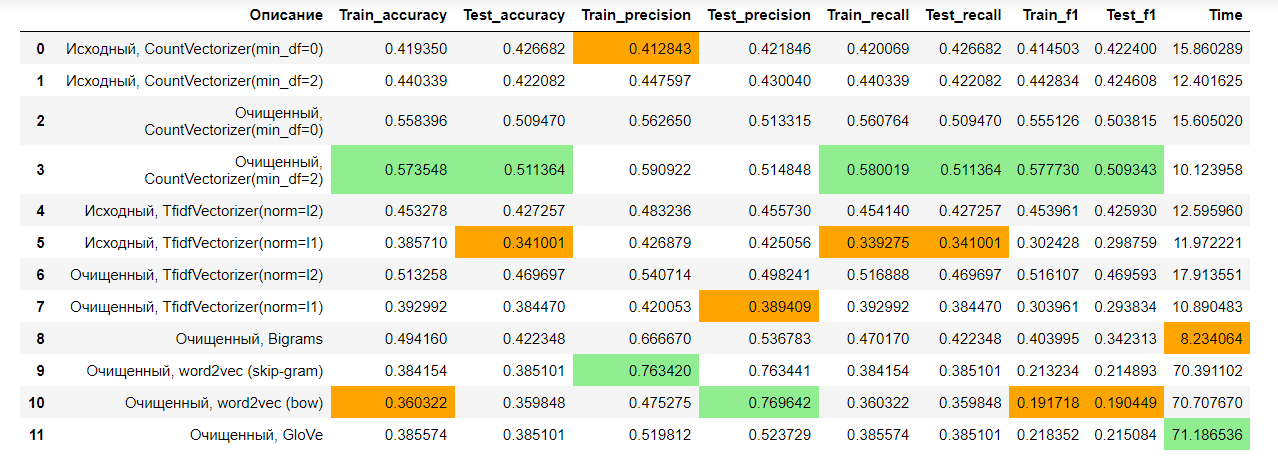